**Name: A Rahul**  
**Reg. No.: 20BRS1102**

Exercise 1: Google-Net Model Execution

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model

In [2]:
(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool):
  path1 = layers.Conv2D(filters_1x1, (1, 1), padding='same',    activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
  path2 = layers.Conv2D(filters_3x3, (1, 1), padding='same', activation='relu')(path2)
  path3 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
  path3 = layers.Conv2D(filters_5x5, (1, 1), padding='same', activation='relu')(path3)
  path4 = layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
  path4 = layers.Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(path4)
  return tf.concat([path1, path2, path3, path4], axis=3)

In [4]:
inp = layers.Input(shape=(32, 32, 3))
input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inp)
x = layers.Conv2D(64, 7, strides=2, padding='same', activation='relu')(input_tensor)
x = layers.MaxPooling2D(3, strides=2)(x)
x = layers.Conv2D(64, 1, strides=1, padding='same', activation='relu')(x)
x = layers.Conv2D(192, 3, strides=1, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=64, filters_3x3_reduce=96, filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=192, filters_3x3_reduce=96, filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
aux1 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux1 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux1)
aux1 = layers.Flatten()(aux1)
aux1 = layers.Dense(1024, activation='relu')(aux1)
aux1 = layers.Dropout(0.7)(aux1)
aux1 = layers.Dense(10, activation='softmax')(aux1)
x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
aux2 = layers.AveragePooling2D((5, 5), strides=3)(x)
aux2 =layers.Conv2D(128, 1, padding='same', activation='relu')(aux2)
aux2 = layers.Flatten()(aux2)
aux2 = layers.Dense(1024, activation='relu')(aux2)
aux2 = layers.Dropout(0.7)(aux2) 
aux2 = layers.Dense(10, activation='softmax')(aux2)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = layers.MaxPooling2D(3, strides=2)(x)
x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(10, activation='softmax')(x)

In [5]:
model = Model(inputs = inp, outputs = [out, aux1, aux2])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 55, 55, 64)   0           ['conv2d[0][0]']             

In [7]:
model.compile(optimizer='adam', 
              loss=[losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy,
                    losses.sparse_categorical_crossentropy]
              ,loss_weights=[1, 0.3, 0.3],
              metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  history = model.fit(x_train, [y_train, y_train, y_train], validation_data=(x_val, [y_val, y_val, y_val]), batch_size=256, epochs=5)

Epoch 1/5
227/227 [==============================] - 182s 627ms/step - loss: 1.7607 - dense_4_loss: 1.3064 - dense_1_loss: 0.7165 - dense_3_loss: 0.7976 - dense_4_accuracy: 0.5240 - dense_1_accuracy: 0.7521 - dense_3_accuracy: 0.7201 - val_loss: 0.4208 - val_dense_4_loss: 0.3416 - val_dense_1_loss: 0.1265 - val_dense_3_loss: 0.1376 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.9670 - val_dense_3_accuracy: 0.9620
Epoch 2/5
227/227 [==============================] - 135s 597ms/step - loss: 0.3192 - dense_4_loss: 0.2271 - dense_1_loss: 0.1474 - dense_3_loss: 0.1598 - dense_4_accuracy: 0.9306 - dense_1_accuracy: 0.9549 - dense_3_accuracy: 0.9498 - val_loss: 0.1317 - val_dense_4_loss: 0.0917 - val_dense_1_loss: 0.0631 - val_dense_3_loss: 0.0702 - val_dense_4_accuracy: 0.9700 - val_dense_1_accuracy: 0.9840 - val_dense_3_accuracy: 0.9795
Epoch 3/5
227/227 [==============================] - 135s 596ms/step - loss: 0.1736 - dense_4_loss: 0.1155 - dense_1_loss: 0.0916 - dense_3_loss: 

In [8]:
with tf.device('/device:GPU:0'):
  lst=model.evaluate(x_test,y_test)
lst

313/313 [==============================] - 11s 30ms/step - loss: 0.0665 - dense_4_loss: 0.0462 - dense_1_loss: 0.0328 - dense_3_loss: 0.0346 - dense_4_accuracy: 0.9832 - dense_1_accuracy: 0.9900 - dense_3_accuracy: 0.9875


[0.06647558510303497,
 0.04624173417687416,
 0.03281347081065178,
 0.03463263064622879,
 0.9832000136375427,
 0.9900000095367432,
 0.987500011920929]

Exercise 2: Visualization of 1*1 Convolution

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_59 (Conv2D)          (None, 28, 28, 32)        128       
                                                                 
Total params: 128
Trainable params: 128
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 99ms/step


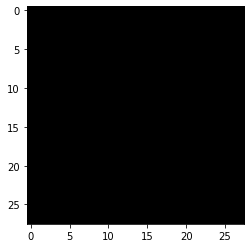

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
import matplotlib.pyplot as plt
import numpy as np

# Define input tensor
input_tensor = np.random.rand(1, 28, 28, 3)

# Define model with 1x1 convolution layer
model = Sequential()
model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(28, 28, 3)))

# Compile model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

# Visualize output of 1x1 convolution layer
output_tensor = model.predict(input_tensor)
plt.imshow(output_tensor[0, :, :, 0], cmap='gray')
plt.show()

Exercise 3: Visualization of Batch Normalization

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2491 - accuracy: 0.9284 - val_loss: 0.1233 - val_accuracy: 0.9635
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1254 - accuracy: 0.9630 - val_loss: 0.0922 - val_accuracy: 0.9731
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0924 - accuracy: 0.9720 - val_loss: 0.0782 - val_accuracy: 0.9756
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0745 - accuracy: 0.9776 - val_loss: 0.0824 - val_accuracy: 0.9750
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0625 - accuracy: 0.9811 - val_loss: 0.0740 - val_accuracy: 0.9772
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0521 - accuracy: 0.9842 - val_loss: 0.0647 - val_accuracy: 0.9805
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0467 - accuracy: 0.9847 - val_loss: 0.0654 - val_accuracy:

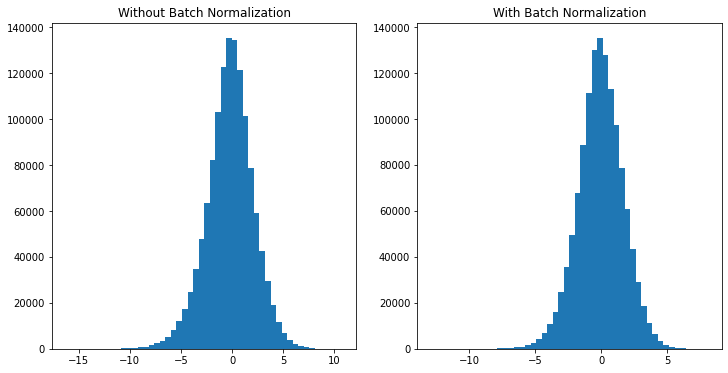

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the neural network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
with tf.device('/device:GPU:0'):
  history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Get the activations of the second layer with and without batch normalization
layer_activations = tf.keras.models.Model(inputs=model.inputs, outputs=[model.layers[1].output, model.layers[2].output])
activations_without_bn, activations_with_bn = layer_activations.predict(x_test)

# Visualize the activations
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.hist(activations_without_bn.flatten(), bins=50)
plt.title('Without Batch Normalization')
plt.subplot(1, 2, 2)
plt.hist(activations_with_bn.flatten(), bins=50)
plt.title('With Batch Normalization')
plt.show()
